Author: Pushkar Patel

# Task 2 - Part 1

Imports

In [10]:
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

Extracting the imges

In [2]:
shutil.unpack_archive('trainPart1.zip', '../input/trainpart1zip')

## Inspecting the image

Browsing through the dataset, we can see that there a total of 62 classes - 10 numbers from 0 to 9, 26 lowercase alphabets and 26 uppercase alphabets, having 40 examples each.

Inspecting the image to view its dimensions and colour channels

(900, 1200, 3)
RGB


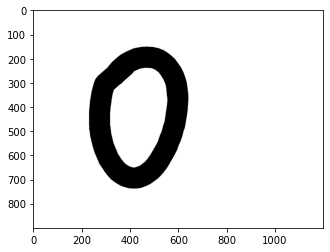

In [ ]:
image = Image.open('../input/trainpart1zip/train/Sample001/img001-001.png')
np_image = np.array(image)
print(np_image.shape)
print(image.mode)
imshow(image)

The image is of dimension 900x1200 with three colour channels. Looking at the images in the directory, I found that all the images are black and white and contain only handwritten digits or alphabets. We can convert them to single grayscale colour channel to reduce computations, improve speed and make the architecture less compled.

## Preprossing the images to convert test and validation input and labels

NOTE: Initially, I tried to build the network on the full image dimension of 900x1200, but that just overloaded the memory with too many parameters. Scaling down the dimensions, I found that reducing the image by 20x i.e. image of dimension 45x60 has comparatively smaller number of parameters to train and the images are still recognizable from each other.

I'll use ImageDataGenerator from Keras to preprocess and split the training images into train and validations sets.

I've normalized all pixel values to be in the range of 0 to 1 for the data to have similar range.

I split the training and validation sets in 80:20 ratio.

In [3]:
train_datagen1 = ImageDataGenerator(rescale=1./255, validation_split=0.2)

I create the generator object which would generate the training and validation sets. It takes the input from the images folder. I'm reducing the size of the images by 20x while taking the input, and changing the colour channel to grayscale.
Each set is of batch size 64. I chose this as it's a good enough batch size for this size of dataset. The class labels are categorical and are one-hot encoded for all of the 62 classes (10 numbers + 26 lowercase alphabets + 26 uppercase alphabets).

Variables that would be used globally

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = (45, 60)
EPOCHS = 400

In [5]:
train_generator1 = train_datagen1.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='training',
        seed=42,
        shuffle=True)

Found 1984 images belonging to 62 classes.


In [6]:
validation_generator1 = train_datagen1.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=tf.squeeze(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='validation',
        seed=42,
        shuffle=True)

Found 496 images belonging to 62 classes.


The ImageDataGenerator class has automatically detected the 62 classes and has one-hot encoded them accordingly.

Viewing the generated samples

(64, 45, 60, 1) (64, 62)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


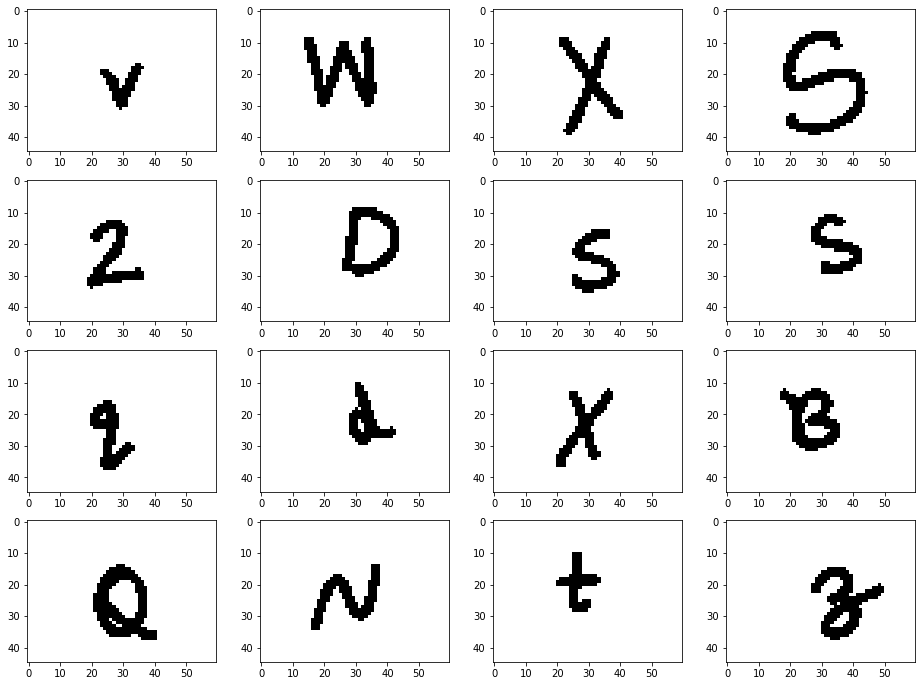

In [ ]:
X_train_batch0, y_train_batch0 = train_generator1.next()
print(X_train_batch0.shape, y_train_batch0.shape)
print(y_train_batch0[0])
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_train_batch0[i]), cmap='gray')
plt.show() 

(64, 45, 60, 1) (64, 62)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


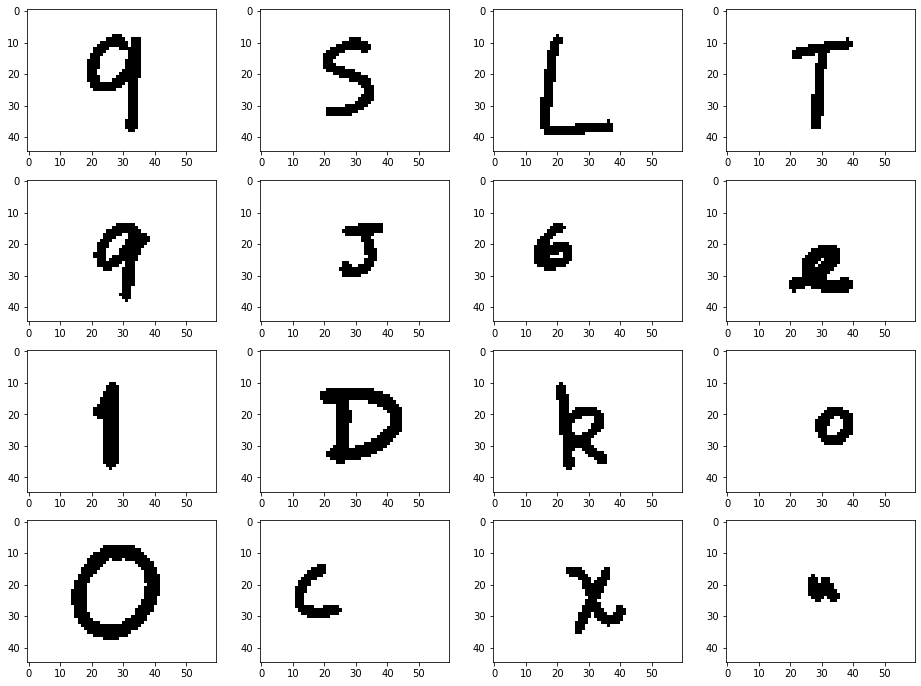

In [ ]:
X_validation_batch0, y_validation_batch0 = validation_generator1.next()
print(X_validation_batch0.shape, y_validation_batch0.shape)
print(y_validation_batch0[0])
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_validation_batch0[i]), cmap='gray')
plt.show() 

## Building the model

### Experiment 1: Building the first model inspired from LeNet

I quickly build a first model, which inspired by the original LeNet, with slight modifications, to check how it performs and will then tune the hyperparameter accordingly. I also use dropouts with a probability of 0.4 for each Fully Connected Layer.

In [ ]:
model1 = Sequential()

# 1st Convolution Layer
model1.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1), kernel_size=(5,5), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model1.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model1.add(Flatten())

# 1st Fully Connected Layer
model1.add(Dense(256, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# 2nd Fully Connected Layer
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# Output Layer
model1.add(Dense(62, activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 45, 60, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 60, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 30, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 26, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 26, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 13, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1872)              0

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Using Early Stopping

In [7]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
    restore_best_weights=True,
    verbose=1)

Saving the checkpoint

In [ ]:
checkpoint_filepath1 = 'exp1/checkpoint'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

I train the model for 400 epochs and use early stopping with a patience level of 20 epochs in order to prevent model from overfitting and save the best weights of the mode.

In [ ]:
history1 = model1.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback1, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 43s 1s/step - loss: 4.7297 - accuracy: 0.0399 - val_loss: 4.1328 - val_accuracy: 0.0268
Epoch 2/400
31/31 [==============================] - 34s 1s/step - loss: 3.5383 - accuracy: 0.1537 - val_loss: 4.2610 - val_accuracy: 0.0179
Epoch 3/400
31/31 [==============================] - 35s 1s/step - loss: 2.9516 - accuracy: 0.2491 - val_loss: 4.5346 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 35s 1s/step - loss: 2.4749 - accuracy: 0.3632 - val_loss: 4.8323 - val_accuracy: 0.0179
Epoch 5/400
31/31 [==============================] - 34s 1s/step - loss: 2.1175 - accuracy: 0.4701 - val_loss: 5.0776 - val_accuracy: 0.0179
Epoch 6/400
31/31 [==============================] - 34s 1s/step - loss: 1.8282 - accuracy: 0.5311 - val_loss: 5.4448 - val_accuracy: 0.0179
Epoch 7/400
31/31 [==============================] - 34s 1s/step - loss: 1.6815 - accuracy: 0.5558 - val_loss: 5.6547 - val_accuracy: 0.0156
Epoch 8/400
3

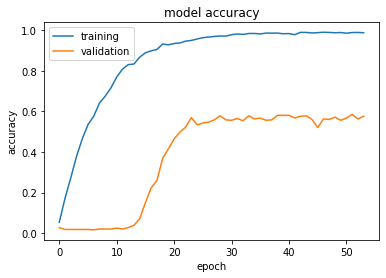

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

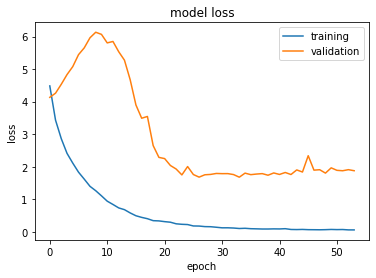

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

The model performs well on the training set but goes not generalizes well on the validation set. The model is overfitting on the training data.

One reason for the overfitting can be that there's not enough training data. For this part of the task, this cannot be improved upon. So, I'll try other ways to reduce overfitting:
- Data Augmentation
- Regularizarion
- Using different activation function
- Changing the model architecture

### Experiment 2: Augmenting training data

I augment the data by randomly shearing it by a range of 0.1 and rotating it by a range of 0.5 degrees. 

So, these augmentation methods should help generalize better on unseen images.

#### **Sidenote**: On using other data augmentation techniques

I tried other parameters tool, like horizontal and vertical shifts but, they blurred the images and the training set and they didn't really looked like the validation samples anymore (I also tested them for a small epoch and they were actually giving worse results than the first experiment). I'll show some samples to see why I did not augment much on these images, before going forward with the model building.

##### Unaugmented data

Found 2480 images belonging to 62 classes.


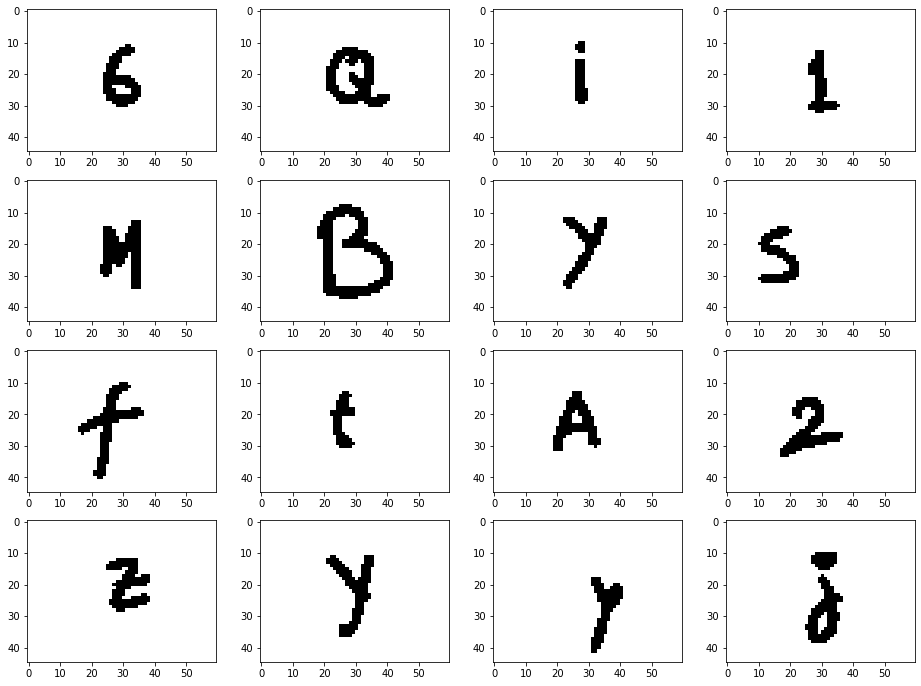

In [ ]:
no_augmentation = ImageDataGenerator(rescale=1./255)

no_augmentation_gen = no_augmentation.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_no_aug, _ = no_augmentation_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_no_aug[i]), cmap='gray')
plt.show() 

##### Checking rotation with max angle of 15

Found 2480 images belonging to 62 classes.


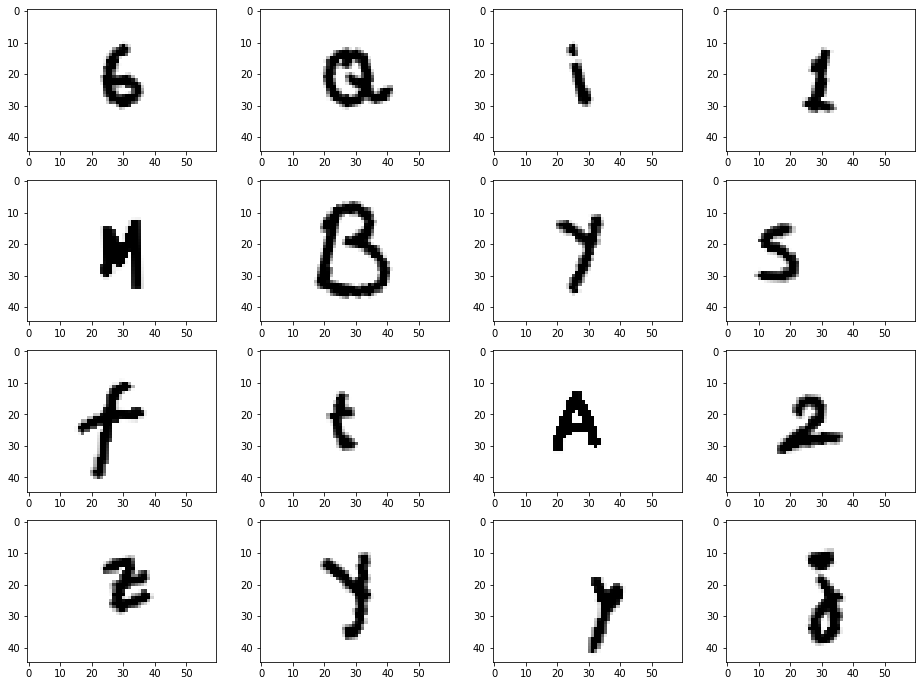

In [ ]:
augmentation_test_rotation = ImageDataGenerator(rescale=1./255, rotation_range=15)

augmentation_test_rotation_gen = augmentation_test_rotation.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_rot, _ = augmentation_test_rotation_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_rot[i]), cmap='gray')
plt.show() 

##### Checking shear with max shear of 0.3

Found 2480 images belonging to 62 classes.


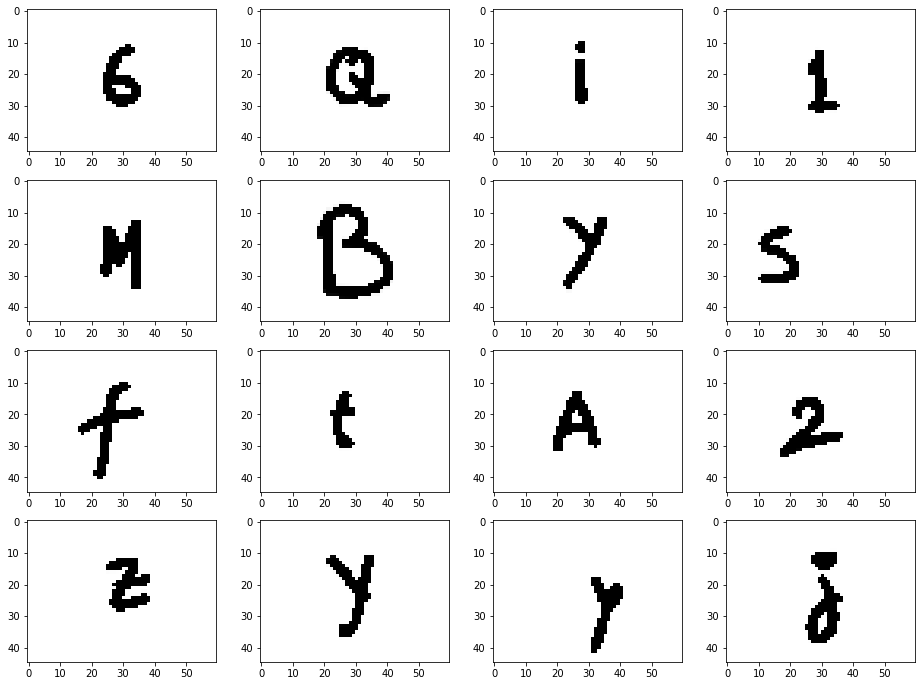

In [ ]:
augmentation_test_shear = ImageDataGenerator(rescale=1./255, shear_range=0.3)

augmentation_test_shear_gen = augmentation_test_shear.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_shear, _ = augmentation_test_shear_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_shear[i]), cmap='gray')
plt.show() 

##### Checking zoom with max zoom of 0.2

Found 2480 images belonging to 62 classes.


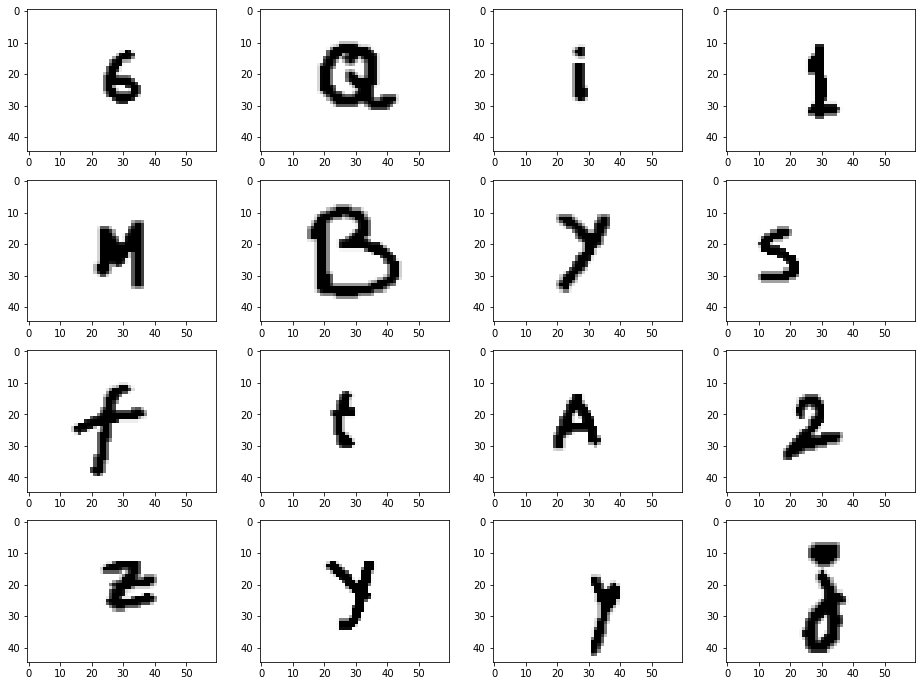

In [ ]:
augmentation_test_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.2)

augmentation_test_zoom_gen = augmentation_test_zoom.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_zoom, _ = augmentation_test_zoom_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_zoom[i]), cmap='gray')
plt.show() 

##### Checking with horizontal and vertical shift of 0.2

Found 2480 images belonging to 62 classes.


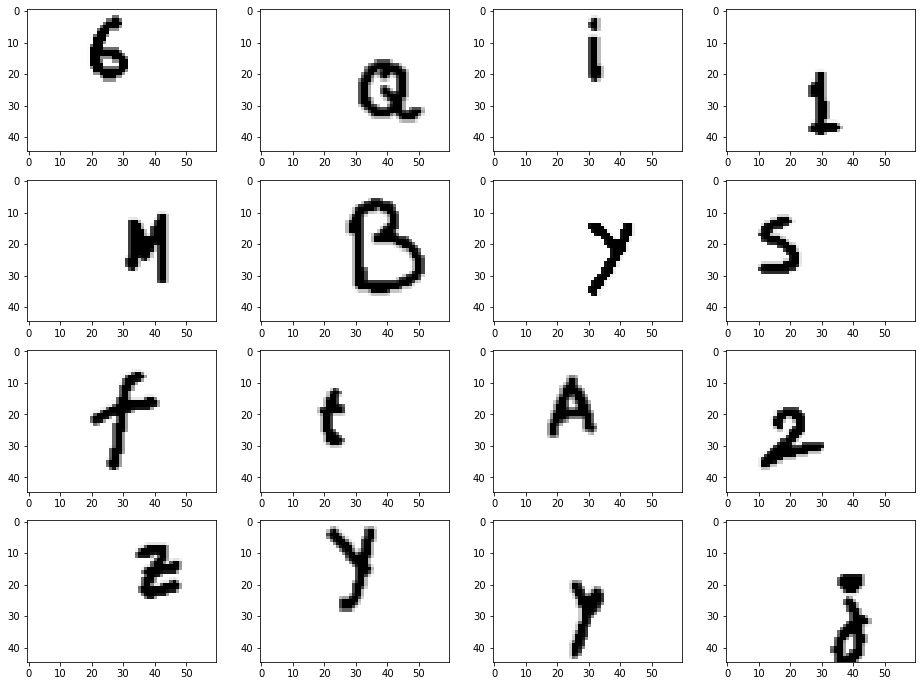

In [ ]:
augmentation_test_shift = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2)

augmentation_test_shift_gen = augmentation_test_shift.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_shift, _ = augmentation_test_shift_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_shift[i]), cmap='gray')
plt.show() 

#### Conclusion: On what augmentation to choose

These augmentations don't turn out very well. They look very different form the training data. I think the closest is the shear, but there's no noticeable effect that I can see from the naked eye. I think I'll still go on with a little of shear and a little of rotation and see how the model performs.

In [ ]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.1,
    rotation_range=0.5)

validation_datagen2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

In [ ]:
train_generator2 = train_datagen2.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='training',
        seed=42,
        shuffle=True)

Found 1984 images belonging to 62 classes.


In [ ]:
validation_generator2 = validation_datagen2.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='validation',
        seed=42,
        shuffle=True)

Found 496 images belonging to 62 classes.


Viewing the Generated samples

(64, 45, 60, 1) (64, 62)


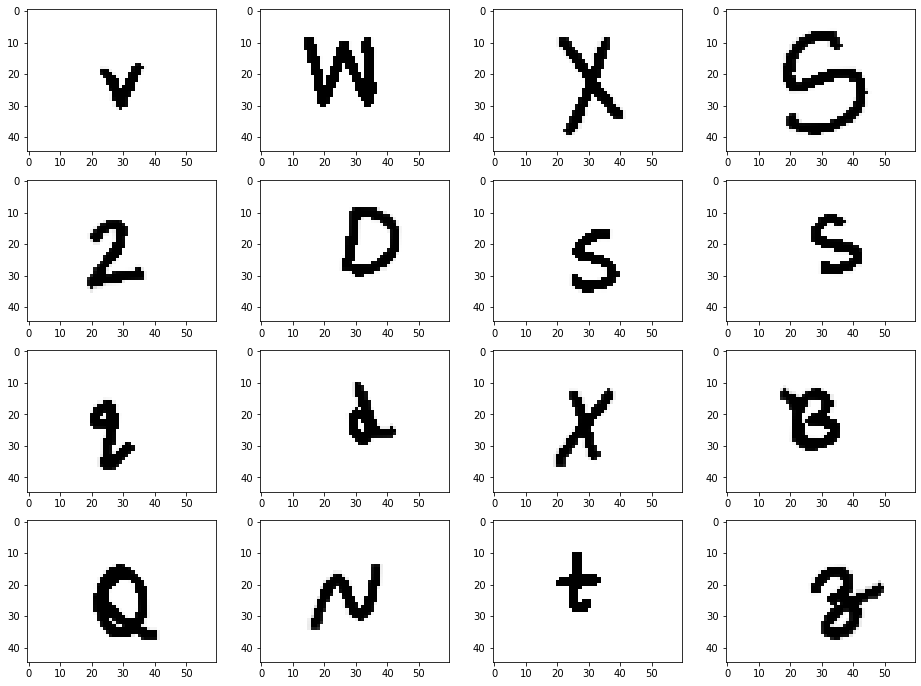

In [ ]:
X_train_batch0, y_train_batch0 = train_generator2.next()
print(X_train_batch0.shape, y_train_batch0.shape)
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_train_batch0[i]), cmap='gray')
plt.show() 

(64, 45, 60, 1) (64, 62)


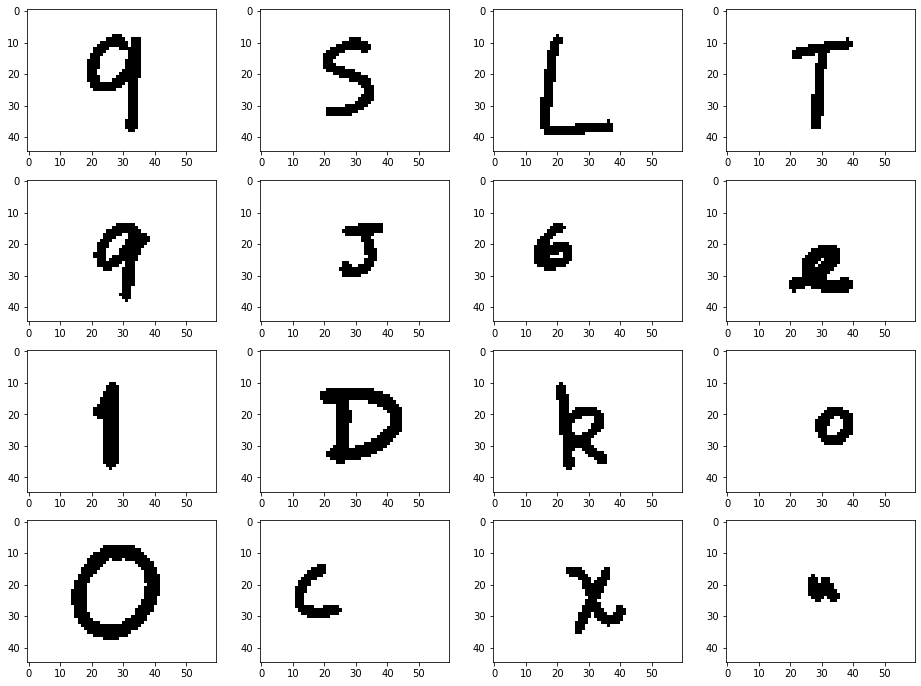

In [ ]:
X_validation_batch0, y_validation_batch0 = validation_generator2.next()
print(X_validation_batch0.shape, y_validation_batch0.shape)
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_validation_batch0[i]), cmap='gray')
plt.show() 

Using the same architecture as before

In [ ]:
model2 = Sequential()

# 1st Convolution Layer
model2.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1), kernel_size=(5,5), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model2.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model2.add(Flatten())

# 1st Fully Connected Layer
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 2nd Fully Connected Layer
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# Output Layer
model2.add(Dense(62, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 45, 60, 6)         156       
_________________________________________________________________
batch_normalization_8 (Batch (None, 45, 60, 6)         24        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 30, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 26, 16)        2416      
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 26, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 13, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1872)             

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the checkpoint

In [ ]:
checkpoint_filepath2 = 'exp2/checkpoint'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history2 = model2.fit(
    train_generator2,
    epochs=EPOCHS,
    validation_data=validation_generator2,
    steps_per_epoch = train_generator2.samples // BATCH_SIZE,
    validation_steps = validation_generator2.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback2, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 37s 1s/step - loss: 4.8922 - accuracy: 0.0325 - val_loss: 4.1346 - val_accuracy: 0.0201
Epoch 2/400
31/31 [==============================] - 35s 1s/step - loss: 3.6093 - accuracy: 0.1459 - val_loss: 4.1228 - val_accuracy: 0.0290
Epoch 3/400
31/31 [==============================] - 35s 1s/step - loss: 3.0967 - accuracy: 0.2445 - val_loss: 4.1612 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 35s 1s/step - loss: 2.5994 - accuracy: 0.3480 - val_loss: 4.2471 - val_accuracy: 0.0223
Epoch 5/400
31/31 [==============================] - 35s 1s/step - loss: 2.3611 - accuracy: 0.3881 - val_loss: 4.4078 - val_accuracy: 0.0268
Epoch 6/400
31/31 [==============================] - 35s 1s/step - loss: 2.0162 - accuracy: 0.4768 - val_loss: 4.4157 - val_accuracy: 0.0312
Epoch 7/400
31/31 [==============================] - 35s 1s/step - loss: 1.7933 - accuracy: 0.5240 - val_loss: 4.4367 - val_accuracy: 0.0357
Epoch 8/400
3

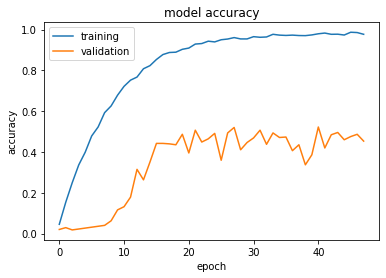

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

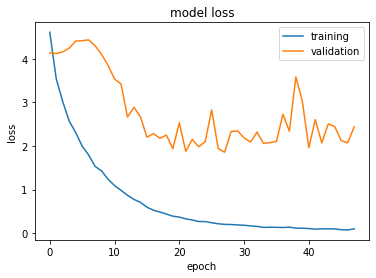

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

We see that this actually performs worse than the first experiment. I think this is so becuase in this case, even slightly augmenting data leads to larger variations and since we don't have a lot of training samples, it still overfits to this data and does not generalize well on the validation set.

### Experiment 3: Using different activation function

#### Using Mish Activation

From refs. [4] and [5], I will use the new Mish activation over ReLU. I'll use the training samples from first experiment as they gave better results than the second experiment and will use the same activation.

In [8]:
# Mish Activation Function
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.math.log(1+tf.exp(x))))(x)

In [ ]:
model3 = Sequential()

# 1st Convolution Layer
model3.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1),
                  kernel_size=(5,5), padding='same', activation=mish))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model3.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model3.add(Flatten())

# 1st Fully Connected Layer
model3.add(Dense(256, activation=mish))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

# 2nd Fully Connected Layer
model3.add(Dense(128, activation=mish))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

# Output Layer
model3.add(Dense(62, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 45, 60, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 60, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 30, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 26, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 26, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 13, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1872)              0

In [ ]:
model3.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the checkpoint

In [ ]:
checkpoint_filepath3 = 'exp3/checkpoint'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history3 = model3.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback3, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 61s 984ms/step - loss: 4.8382 - accuracy: 0.0325 - val_loss: 4.1591 - val_accuracy: 0.0156
Epoch 2/400
31/31 [==============================] - 30s 973ms/step - loss: 3.5108 - accuracy: 0.1671 - val_loss: 4.4229 - val_accuracy: 0.0201
Epoch 3/400
31/31 [==============================] - 30s 974ms/step - loss: 2.8792 - accuracy: 0.2770 - val_loss: 4.8254 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 30s 979ms/step - loss: 2.4508 - accuracy: 0.3762 - val_loss: 5.2647 - val_accuracy: 0.0179
Epoch 5/400
31/31 [==============================] - 30s 974ms/step - loss: 2.1049 - accuracy: 0.4616 - val_loss: 5.6886 - val_accuracy: 0.0179
Epoch 6/400
31/31 [==============================] - 30s 974ms/step - loss: 1.8642 - accuracy: 0.5457 - val_loss: 5.7846 - val_accuracy: 0.0134
Epoch 7/400
31/31 [==============================] - 30s 969ms/step - loss: 1.5534 - accuracy: 0.6157 - val_loss: 5.8400 - val_accuracy:

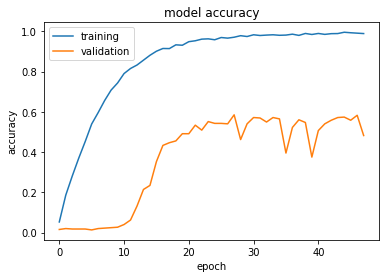

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

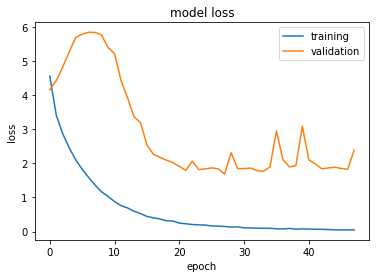

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This model performs "slightly" better than our model from Experiment 1 and also does so in less epochs. However, there is some variance as the model overfits. We used early stopping with patience level 20, so our model gives best results at around epoch 28.

#### Experiment 7: Using higher temperature in Softmax

Higher temperature in softmax helps get 'softer' weights. This is actually the last experiment that I perform here, but put it here in the middle because it fits this section better.

In [11]:
model7 = Sequential()

# 1st Convolution Layer
model7.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1),
                  kernel_size=(5,5), padding='same', activation=mish))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model7.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model7.add(Flatten())

# 1st Fully Connected Layer
model7.add(Dense(256, activation=mish))
model7.add(BatchNormalization())
model7.add(Dropout(0.4))

# 2nd Fully Connected Layer
model7.add(Dense(128, activation=mish))
model7.add(BatchNormalization())
model7.add(Dropout(0.4))

# Output Layer
# Increasing the softmax temperature
temp = 5
model7.add(Lambda(lambda x: x / temp))
model7.add(Dense(62, activation='softmax'))

In [12]:
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 45, 60, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 60, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 30, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 26, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 26, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 13, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1872)              0

In [13]:
model7.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [18]:
checkpoint_filepath7 = 'exp7/checkpoint'
model_checkpoint_callback7 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath7,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [19]:
history7 = model7.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback7, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 68s 1s/step - loss: 4.1001 - accuracy: 0.0498 - val_loss: 4.1148 - val_accuracy: 0.0246
Epoch 2/400
31/31 [==============================] - 38s 1s/step - loss: 3.7522 - accuracy: 0.1887 - val_loss: 4.1053 - val_accuracy: 0.0179
Epoch 3/400
31/31 [==============================] - 38s 1s/step - loss: 3.5069 - accuracy: 0.3088 - val_loss: 4.1128 - val_accuracy: 0.0156
Epoch 4/400
31/31 [==============================] - 38s 1s/step - loss: 3.3064 - accuracy: 0.3704 - val_loss: 4.1244 - val_accuracy: 0.0290
Epoch 5/400
31/31 [==============================] - 38s 1s/step - loss: 3.0649 - accuracy: 0.4657 - val_loss: 4.1426 - val_accuracy: 0.0290
Epoch 6/400
31/31 [==============================] - 38s 1s/step - loss: 2.8262 - accuracy: 0.5386 - val_loss: 4.1336 - val_accuracy: 0.0246
Epoch 7/400
31/31 [==============================] - 38s 1s/step - loss: 2.5745 - accuracy: 0.6177 - val_loss: 4.1471 - val_accuracy: 0.0290
Epoch 8/400
3

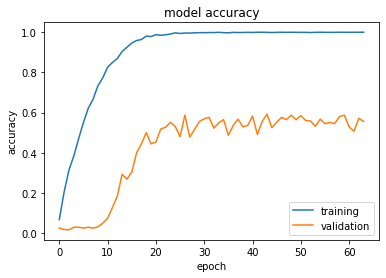

In [20]:
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

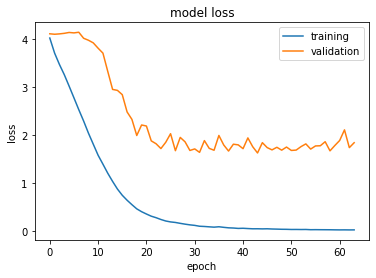

In [21]:
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

### Experiment 4: Changing the Model Architecture

From ref. [1] and [2], I modify the architecture to see if it gives better results. This model actually gives very good results on the MNIST dataset.

In [ ]:
model4 = Sequential()

# 1st Convolution Layer
model4.add(Conv2D(32, input_shape=(*IMAGE_SIZE, 1), kernel_size=3, activation=mish))
model4.add(BatchNormalization())
model4.add(Conv2D(32, kernel_size=3, activation=mish))
model4.add(BatchNormalization())
model4.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation=mish))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

# 2nd Convolution Layer
model4.add(Conv2D(64, kernel_size=3, activation=mish))
model4.add(BatchNormalization())
model4.add(Conv2D(64, kernel_size=3, activation=mish))
model4.add(BatchNormalization())
model4.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=mish))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

# 3rd Convolution Layer
model4.add(Conv2D(128, kernel_size = 4, activation=mish))
model4.add(BatchNormalization())

# Passing to a Fully Connected Layer
model4.add(Flatten())
model4.add(Dropout(0.4))

# Output Layer
model4.add(Dense(62, activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 43, 58, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 43, 58, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 56, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 41, 56, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 28, 32)        25632     
_________________________________________________________________
batch_normalization_6 (Batch (None, 21, 28, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 28, 32)       

In [ ]:
model4.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the Checkpoint

In [ ]:
checkpoint_filepath4 = 'exp4/checkpoint'
model_checkpoint_callback4 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath4,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history4 = model4.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback4, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 32s 1s/step - loss: 5.3313 - accuracy: 0.0398 - val_loss: 4.6788 - val_accuracy: 0.0156
Epoch 2/400
31/31 [==============================] - 30s 979ms/step - loss: 3.1859 - accuracy: 0.2657 - val_loss: 5.6807 - val_accuracy: 0.0179
Epoch 3/400
31/31 [==============================] - 30s 979ms/step - loss: 2.0750 - accuracy: 0.4680 - val_loss: 6.7425 - val_accuracy: 0.0156
Epoch 4/400
31/31 [==============================] - 30s 974ms/step - loss: 1.4255 - accuracy: 0.6142 - val_loss: 5.9356 - val_accuracy: 0.0201
Epoch 5/400
31/31 [==============================] - 30s 974ms/step - loss: 1.0759 - accuracy: 0.6824 - val_loss: 5.0072 - val_accuracy: 0.0357
Epoch 6/400
31/31 [==============================] - 30s 983ms/step - loss: 0.7809 - accuracy: 0.7552 - val_loss: 5.1140 - val_accuracy: 0.0446
Epoch 7/400
31/31 [==============================] - 30s 973ms/step - loss: 0.5856 - accuracy: 0.8184 - val_loss: 9.4351 - val_accuracy: 0.

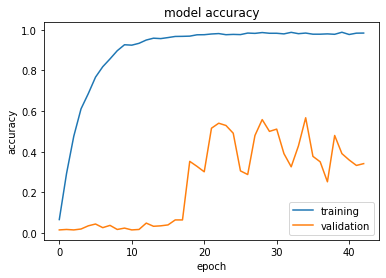

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

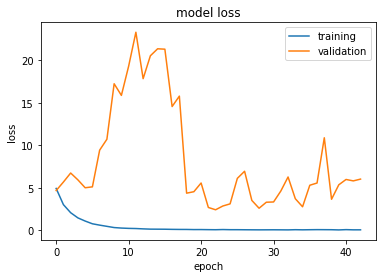

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This is is actually worse than all other experiments we have done so far. Though the training accuracy converges fast, the validation accuracy and loss have too much variance.

### Experiment 5: Changing the Model Architecture even further: Using Efficientnet

Effecient Net is being used a lot nowdays so, I'll see how this architecture works for this dataset. I don't have very high hopes for this because:
1. We are not using pre-trained weights
2. We don't have a large trainign data

But I'll still give it a try to see how it does.

For this EfficientNet Model, I would use Early Stopping with larger patience value. This is so because the Keras Website says

> "Note: the accuracy will increase very slowly and may overfit."

on Training a model with EfficientNet from scratch.


Saving the Checkpoint

In [ ]:
checkpoint_filepath5 = 'exp5/checkpoint'
model_checkpoint_callback5 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath5,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

Early Stopping Callback

In [ ]:
early_stopping_callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True,
    verbose=1)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Initializer taken from the source code
DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

# Input Layer
inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 1))

# Efficient layer except the top layer
x = EfficientNetB0(include_top=False, weights=None,
    input_shape=(*IMAGE_SIZE, 1))(inputs)

# Top

# Global Average Pooling Layer
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = tf.keras.layers.Dropout(0.4, name='top_dropout')(x)

# Output Layer
outputs = tf.keras.layers.Dense(62,
    activation='softmax',
    kernel_initializer=DENSE_KERNEL_INITIALIZER,
    name='predictions')(x)

model5 = tf.keras.Model(inputs, outputs)

model5.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

model5.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 45, 60, 1)]       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4048991   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
predictions (Dense)          (None, 62)                79422     
Total params: 4,128,413
Trainable params: 4,086,394
Non-trainable params: 42,019
_________________________________________________________________


In [ ]:
history5 = model5.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback5, early_stopping_callback2]
)

Epoch 1/400
31/31 [==============================] - 42s 1s/step - loss: 4.9151 - accuracy: 0.0201 - val_loss: 4.1315 - val_accuracy: 0.0179
Epoch 2/400
31/31 [==============================] - 32s 1s/step - loss: 4.4224 - accuracy: 0.0468 - val_loss: 4.1495 - val_accuracy: 0.0156
Epoch 3/400
31/31 [==============================] - 32s 1s/step - loss: 4.2469 - accuracy: 0.0709 - val_loss: 4.1952 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 32s 1s/step - loss: 3.8510 - accuracy: 0.1198 - val_loss: 4.2058 - val_accuracy: 0.0134
Epoch 5/400
31/31 [==============================] - 32s 1s/step - loss: 3.4325 - accuracy: 0.2088 - val_loss: 4.2741 - val_accuracy: 0.0156
Epoch 6/400
31/31 [==============================] - 32s 1s/step - loss: 2.8368 - accuracy: 0.3269 - val_loss: 4.3717 - val_accuracy: 0.0179
Epoch 7/400
31/31 [==============================] - 32s 1s/step - loss: 2.2589 - accuracy: 0.4527 - val_loss: 4.7584 - val_accuracy: 0.0156
Epoch 8/400
3

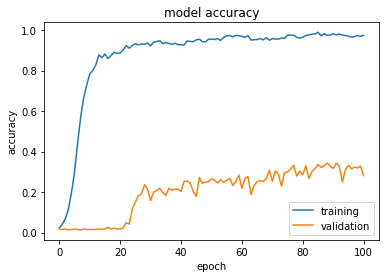

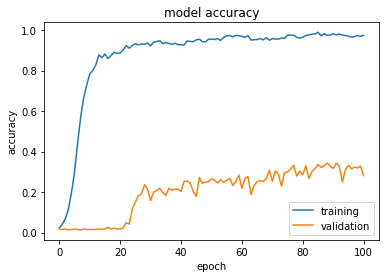

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

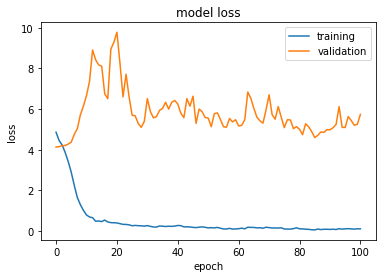

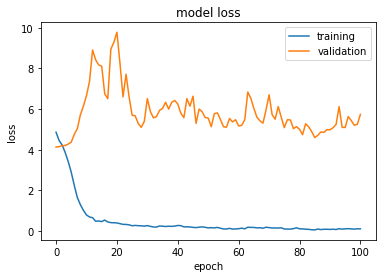

In [ ]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

As expected, this does not converge. Infact, it's not even reaching a 50% accuracy. This accuracy result is similar to the one shown in ref. [6] [here](https://keras.io/img/examples/vision/image_classification_efficientnet_fine_tuning/image_classification_efficientnet_fine_tuning_20_0.png).

### Experiment 6: Reducing Batch Size

Smaller batch sizes tend to converge faster [12]. Hence, I'll reduce the batch size to 32 to see the performance. I'll use the two best models I have achieved form the past experiments 3 and 4.

#### Architecture from Experiment 3

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_generator3 = train_datagen1.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='training',
        seed=42,
        shuffle=True)

validation_generator3 = train_datagen1.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=tf.squeeze(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='validation',
        seed=42,
        shuffle=True)

Found 1984 images belonging to 62 classes.
Found 496 images belonging to 62 classes.


In [ ]:
model6_1 = Sequential()

# 1st Convolution Layer
model6_1.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1),
                  kernel_size=(5,5), padding='same', activation=mish))
model6_1.add(BatchNormalization())
model6_1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model6_1.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model6_1.add(BatchNormalization())
model6_1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model6_1.add(Flatten())

# 1st Fully Connected Layer
model6_1.add(Dense(256, activation=mish))
model6_1.add(BatchNormalization())
model6_1.add(Dropout(0.4))

# 2nd Fully Connected Layer
model6_1.add(Dense(128, activation=mish))
model6_1.add(BatchNormalization())
model6_1.add(Dropout(0.4))

# Output Layer
model6_1.add(Dense(62, activation='softmax'))

In [ ]:
model6_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 45, 60, 6)         156       
_________________________________________________________________
batch_normalization_19 (Batc (None, 45, 60, 6)         24        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 30, 6)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 18, 26, 16)        2416      
_________________________________________________________________
batch_normalization_20 (Batc (None, 18, 26, 16)        64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 13, 16)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1872)             

In [ ]:
model6_1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the Model Checkpoint

In [ ]:
checkpoint_filepath6_1 = 'exp6_1/checkpoint'
model_checkpoint_callback6_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath6_1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history6_1 = model6_1.fit(
    train_generator3,
    epochs=EPOCHS,
    validation_data=validation_generator3,
    steps_per_epoch = train_generator3.samples // BATCH_SIZE,
    validation_steps = validation_generator3.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback6_1, early_stopping_callback]
)

Epoch 1/400
62/62 [==============================] - 33s 513ms/step - loss: 4.6588 - accuracy: 0.0335 - val_loss: 4.3612 - val_accuracy: 0.0167
Epoch 2/400
62/62 [==============================] - 31s 499ms/step - loss: 3.3342 - accuracy: 0.1942 - val_loss: 4.6904 - val_accuracy: 0.0250
Epoch 3/400
62/62 [==============================] - 31s 495ms/step - loss: 2.6940 - accuracy: 0.3107 - val_loss: 4.8908 - val_accuracy: 0.0208
Epoch 4/400
62/62 [==============================] - 31s 501ms/step - loss: 2.2589 - accuracy: 0.4113 - val_loss: 4.9160 - val_accuracy: 0.0083
Epoch 5/400
62/62 [==============================] - 30s 493ms/step - loss: 1.8811 - accuracy: 0.5197 - val_loss: 4.5471 - val_accuracy: 0.0354
Epoch 6/400
62/62 [==============================] - 31s 494ms/step - loss: 1.5784 - accuracy: 0.5897 - val_loss: 3.7062 - val_accuracy: 0.1250
Epoch 7/400
62/62 [==============================] - 31s 496ms/step - loss: 1.3584 - accuracy: 0.6500 - val_loss: 4.0543 - val_accuracy:

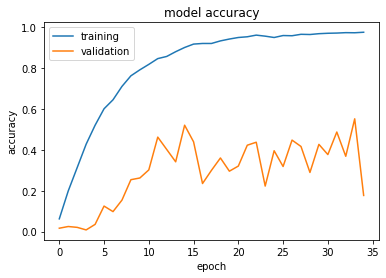

In [ ]:
plt.plot(history6_1.history['accuracy'])
plt.plot(history6_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

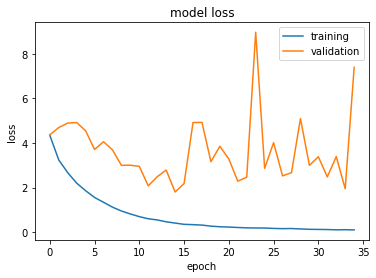

In [ ]:
plt.plot(history6_1.history['loss'])
plt.plot(history6_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#### Architecture from Experiment 4

In [ ]:
model6_2 = Sequential()

# 1st Convolution Layer
model6_2.add(Conv2D(32, input_shape=(*IMAGE_SIZE, 1), kernel_size=3, activation=mish))
model6_2.add(BatchNormalization())
model6_2.add(Conv2D(32, kernel_size=3, activation=mish))
model6_2.add(BatchNormalization())
model6_2.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation=mish))
model6_2.add(BatchNormalization())
model6_2.add(Dropout(0.4))

# 2nd Convolution Layer
model6_2.add(Conv2D(64, kernel_size=3, activation=mish))
model6_2.add(BatchNormalization())
model6_2.add(Conv2D(64, kernel_size=3, activation=mish))
model6_2.add(BatchNormalization())
model6_2.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=mish))
model6_2.add(BatchNormalization())
model6_2.add(Dropout(0.4))

# 3rd Convolution Layer
model6_2.add(Conv2D(128, kernel_size = 4, activation=mish))
model6_2.add(BatchNormalization())

# Passing to a Fully Connected Layer
model6_2.add(Flatten())
model6_2.add(Dropout(0.4))

# Output Layer
model6_2.add(Dense(62, activation='softmax'))

In [ ]:
model6_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 43, 58, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 43, 58, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 56, 32)        9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 41, 56, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 28, 32)        25632     
_________________________________________________________________
batch_normalization_14 (Batc (None, 21, 28, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 21, 28, 32)       

In [ ]:
model6_2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the Model Checkpoint

In [ ]:
checkpoint_filepath6_2 = 'exp6_2/checkpoint'
model_checkpoint_callback6_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath6_2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history6_2 = model6_2.fit(
    train_generator3,
    epochs=EPOCHS,
    validation_data=validation_generator3,
    steps_per_epoch = train_generator3.samples // BATCH_SIZE,
    validation_steps = validation_generator3.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback6_2, early_stopping_callback]
)

Epoch 1/400
62/62 [==============================] - 33s 506ms/step - loss: 5.2828 - accuracy: 0.0535 - val_loss: 5.1547 - val_accuracy: 0.0167
Epoch 2/400
62/62 [==============================] - 31s 499ms/step - loss: 2.6122 - accuracy: 0.3701 - val_loss: 6.4788 - val_accuracy: 0.0250
Epoch 3/400
62/62 [==============================] - 31s 499ms/step - loss: 1.6781 - accuracy: 0.5677 - val_loss: 6.7860 - val_accuracy: 0.0500
Epoch 4/400
62/62 [==============================] - 31s 498ms/step - loss: 1.2515 - accuracy: 0.6698 - val_loss: 7.6091 - val_accuracy: 0.0625
Epoch 5/400
62/62 [==============================] - 31s 501ms/step - loss: 1.0160 - accuracy: 0.7232 - val_loss: 11.6267 - val_accuracy: 0.0479
Epoch 6/400
62/62 [==============================] - 31s 498ms/step - loss: 0.7533 - accuracy: 0.7794 - val_loss: 6.4720 - val_accuracy: 0.1646
Epoch 7/400
62/62 [==============================] - 31s 497ms/step - loss: 0.5145 - accuracy: 0.8392 - val_loss: 14.5081 - val_accurac

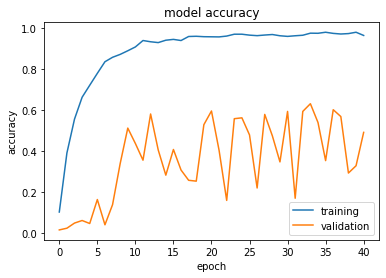

In [ ]:
plt.plot(history6_2.history['accuracy'])
plt.plot(history6_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

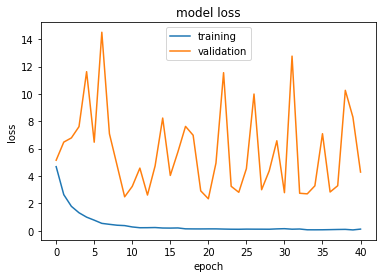

In [ ]:
plt.plot(history6_2.history['loss'])
plt.plot(history6_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

We see that batch size of 32 actually performs worse than that of 64.

## Observations form these experiments

- I downscaled the images by 20x while making sure that the images are still recognizable from each other. This would reduce the number of parameters in our network.
- I started with a modified version of the original LeNet, which was used to classify on the MNIST dataset, as our current dataset closely resembles it, I got an accuracy of a little below 60%.
- Data Augmentation did not help for this dataset as the augmented data was very different from the original data and it actually performed worse. I didn not use Data augmentation for later experiments.
- I tried the Mish Activation function instead of ReLU and it reached the the same accuracy in lesser epochs, however it had some variance issues for the training accuracy in the later epochs.
- I tried different architectures: One which is known to give pretty good accuracy on the MNIST dataset in Kaggle Competitions and one Modified EfficientNet Architecture.
    - The first of them gave similar result to the original LeNet and in lesser epochs, but had larger variance in training accuracy in the later epochs.
    - The EfficientNet architecture actually gave the worst results in all of the experiments, but I think this was due to the scarcity of training data and not using a pretrained model.
- I tried reducing Batch size form 64 to 32, but it gave worse results than 64.
- Lastly, in experiment 7, (which I actually added in the section of experiment 3), I used higher temperature to achieve 'softer' softmax outputs, alongwith the Mish Activation and it gave the best accuracy on the validations et so far.
- The best validation accuracy that I achieved was 59.15% in Experiment 7.


## Conclusions and Future Improvements

- Overall, I think the original LeNet with Mish activation and high temperature softmax from Experiment 7 and the Model Architecture from Experiment 4, both gave good results. Clearly, the models were overfitting the data and I think that if trained with more data, they would perform better. For the future parts of this task, I would be using these two architectures, and would even like to try high temperature softmax for Expriment 4's architecture.
- EfficientNet can give better results than from Experiment 5 but again, it neeeds more data and some pre-trainined weights. EfficientNetV2, released recently can also be a good model, but I can't find an Open Source Implementation of it and it's a little complex to build it in this duration, so I didn not try it, but I'm sure that it would give better results than what I got from EfficientNet here.
- I have tuned the hyperparameters from what I could read online. However, I think using [Weights & Biases Sweeps](https://docs.wandb.com/sweeps/overview) would give better insights. I got to know about this relatively late and there was not much time left to set it up. But it would be sweet in the future to improve the model using this.

# References

- [1] [EMNIST handwritten character recognition with Deep Learning](https://medium.com/@mrkardostamas/emnist-handwritten-character-recognition-with-deep-learning-b5d61ac1aab7)
- [2] [How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist)
- [3] [Swish Vs Mish: Latest Activation Functions](https://krutikabapat.github.io/Swish-Vs-Mish-Latest-Activation-Functions/)
- [4] [Mish Class Definition in Keras](https://gist.github.com/digantamisra98/35ca0ec94ebefb99af6f444922fa52cd)
- [5] [Mnist_EfficientNet Kaggle Notebook](https://www.kaggle.com/ateplyuk/mnist-efficientnet)
- [6] [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#training-a-model-from-scratch)
- [7] [Keras EfficientNet Implementation Source Code](https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/applications/efficientnet.py#L517-L540)
- [8] [Keras ModelCheckpoint Documentaion](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)
- [9] [Keras EarlyStopping Documentaion](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- [10] [Keras ImageDataGenerator Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [11] [Keras EfficientNetB0 Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0)
- [12] [Effect of Batch Size on Neural Net Training](https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57)
- [13] [How does temperature affect softmax in machine learning?](http://www.kasimte.com/2020/02/14/how-does-temperature-affect-softmax-in-machine-learning.html)
- [14] [Temperatured softmax · Issue #3092 · keras-team/keras](https://github.com/keras-team/keras/issues/3092)
- [15] [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298.pdf)